In [1]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()

In [2]:
config = {'cores': 1, 'ram': 4096}

In [3]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class CreateData:
    filename: str
    size: int
    out_filename: rf.Output[str] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        arr = list(np.random.randint(1, 11, size=self.size))
        text_str = ', '.join([str(i) for i in arr])
        
        logger.info(sum(arr))
        
        with open(project_space_path(self.filename), 'w') as f:
            f.write(text_str)
        self.out_filename.put(self.filename)
        
        
@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class STDIn:
    s_file: str
    l_file: str
    s_val: rf.SeriesOutput[int] = rf.Output(transport=rf.KafkaTransport)
    l_val: rf.SeriesOutput[int] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        sftp_client = datasources('test_source').client()
        with sftp_client.open(self.s_file, 'r') as f:
            l = f.read().decode('utf-8')
            
        with sftp_client.open(self.l_file, 'r') as f:
            m = f.read().decode('utf-8')
            
        for i in l.split(', '):
            self.s_val.put(int(i))
            
        for i in m.split(', '):
            self.l_val.put(int(i))

        
@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class ArrayMul:
    array: rf.SeriesInput[int]
    array_out: rf.SeriesOutput[int] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        l = 2 * np.array([i for i in self.array])
        for i in l:
            self.array_out.put(int(i))
        
        
@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class ArrayAdd:
    s_array: rf.SeriesInput[int]
    l_array: rf.SeriesInput[int]
    s_array_out: rf.SeriesOutput[int] = rf.Output(transport=rf.KafkaTransport)
    l_array_out: rf.SeriesOutput[int] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        for i in self.s_array:
            self.s_array_out.put(int(i+1))
        for j in self.l_array:
            self.l_array_out.put(int(j+2))
        
        
@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class ArrayDeOp:
    array: rf.SeriesInput[int]
    k: int
    out_array: rf.Output[np.ndarray] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        l = np.array([i for i in self.array])
        self.out_array.put((l-self.k)//2)
        

@rf.block(executor=rf.ContainerExecutor(cores=config['cores'], memory=config['ram']))
class STDOut:
    in_array: np.ndarray
    out_file: str
    
    def run(self):
        logger.info(sum(self.in_array))
        text_str = ', '.join([str(i) for i in self.in_array])
        with open(project_space_path(self.out_file), 'w') as f:
            f.write(text_str)
            

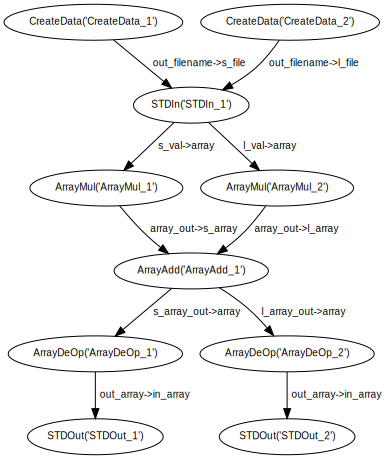

In [4]:
s_filename = "/data/sdk_testbench/input_data/tc_26_small.txt"
l_filename = "/data/sdk_testbench/input_data/tc_26_large.txt"
s_size = 10
l_size = 20
s_output_filename = "/data/sdk_testbench/output_data/tc_26_small_out.txt"
l_output_filename = "/data/sdk_testbench/output_data/tc_26_large_out.txt"

s_create_data = CreateData(filename=s_filename, size=s_size)
l_create_data = CreateData(filename=l_filename, size=l_size)
s_create_data.out_filename = rf.Output.set(transport=rf.KafkaTransport) 
l_create_data.out_filename = rf.Output.set(transport=rf.KafkaTransport) 

std_in = STDIn(s_file=s_create_data.out_filename, l_file=l_create_data.out_filename)
std_in.s_val = rf.Output.set(transport=rf.KafkaTransport) 
std_in.l_val = rf.Output.set(transport=rf.FileTransport)

s_arr_mul = ArrayMul(array=std_in.s_val)
l_arr_mul = ArrayMul(array=std_in.l_val)
s_arr_mul.array_out = rf.Output.set(transport=rf.KafkaTransport)
l_arr_mul.array_out = rf.Output.set(transport=rf.FileTransport)

arr_add = ArrayAdd(s_array=s_arr_mul.array_out, l_array=l_arr_mul.array_out)
arr_add.s_array_out = rf.Output.set(transport=rf.KafkaTransport)
arr_add.l_array_out = rf.Output.set(transport=rf.FileTransport)

s_arr_deop = ArrayDeOp(array=arr_add.s_array_out, k=1)
l_arr_deop = ArrayDeOp(array=arr_add.l_array_out, k=2)
s_arr_deop.out_array = rf.Output.set(transport=rf.FileTransport)
l_arr_deop.out_array = rf.Output.set(transport=rf.FileTransport)

s_stdout = STDOut(in_array=s_arr_deop.out_array, out_file=s_output_filename)
l_stdout = STDOut(in_array=l_arr_deop.out_array, out_file=l_output_filename)

pipeline = rf.Pipeline(name='mix_series_atomic', targets=[s_stdout, l_stdout])
pipeline.show()

In [5]:
def create_pipeline():
    return pipeline